## Dependencies

In [15]:
import torch
print(torch.__version__)

2.5.1


In [20]:
!which python
!pip install pandas ndjson google-cloud-storage

/Users/corentinlaval/Desktop/TSE/FISE3/BigData/BigData/.venv/bin/python


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pandas as pd
from download import download_data_and_parse_it
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
import time
import os


from sklearn.metrics import accuracy_score

batch_size = 32
num_classes = 12
learning_rate = 0.001
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



#import os
#import json
#from google.cloud import storage

# Configurer la variable d'environnement
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./copper-gear-448109-p4-3afc6f7125c4.json"

# Vérifier la variable d'environnement
#credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
#if credentials_path:
#    credentials_path = os.path.abspath(credentials_path)  # Obtenir le chemin absolu
#    print(f"Path to credentials: {credentials_path}")
    
#    if os.path.exists(credentials_path):
        # Charger et afficher le contenu du fichier JSON
#        with open(credentials_path, 'r') as f:
#            credentials_content = json.load(f)
#            print("Credentials file content:")
#            print(json.dumps(credentials_content, indent=4))
#    else:
#        print("Le fichier spécifié n'existe pas.")
#else:
#    print("La variable d'environnement GOOGLE_APPLICATION_CREDENTIALS n'est pas définie.")

# Lister les buckets disponibles
#try:
#    client = storage.Client()
#    buckets = list(client.list_buckets())
#    print(f"Buckets disponibles : {[bucket.name for bucket in buckets]}")
#except Exception as e:
#    print(f"Erreur lors de la connexion à Google Cloud Storage : {e}")

Using cpu device


## Create the dataset

In [18]:
from google.cloud import storage

bucket_name = "quickdraw_dataset"
file_path = "full/simplified/star.ndjson"

try:
    client = storage.Client.create_anonymous_client()  # Client anonyme pour bucket public
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(file_path)

    if blob.exists():
        print(f"Le fichier '{file_path}' existe dans le bucket '{bucket_name}'.")
    else:
        print(f"Le fichier '{file_path}' n'existe pas dans le bucket '{bucket_name}'.")
except Exception as e:
    print(f"Erreur lors de l'accès au bucket : {e}")

    

Le fichier 'full/simplified/star.ndjson' existe dans le bucket 'quickdraw_dataset'.


In [21]:
import ndjson

bucket_name = "quickdraw_dataset"

datasets = ["star", "apple"]

all_dfs = []

for dataset in datasets:
    
    file_path = f"full/simplified/{dataset}.ndjson"
    
    print(f"Téléchargement du fichier : {file_path}")
    try:
        dataset_df = download_data_and_parse_it(bucket_name,file_path)
        all_dfs.append(dataset_df)
    except FileNotFoundError as e:
        print(f"Erreur : {e}")
    except Exception as e:
        print(f"Erreur inattendue : {e}")

# Combine all datasets
df = pd.concat(all_dfs, ignore_index=True)

# Assign class labels using LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['word'])

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

print("size of datasets array :", len(datasets))
    

Téléchargement du fichier : full/simplified/star.ndjson
Données brutes du fichier full/simplified/star.ndjson :
{"word":"star","countrycode":"US","timestamp":"2017-03-07 16:39:23.36509 UTC","recognized":true,"key_id":"5260413706960896","drawing":[[[67,37,30,44,70,105,116,184,192,194,161,190,237,230,185,155,145,110,102,98,96,78,76,70,0,18,35,48,60],[160,220,243,240,226,200,189,251,255,249,160,145,106,103,103,95,72,9,0,5,35,110,104,101,91,128,154,165,166]]]}
{"word":"star","countrycode":"US","timestamp":"2017-03-15 15:13:18.18952 UTC","recognized":true,"key_id":"4853913289228288","drawing":[[[104,106,115,12
Téléchargement du fichier : full/simplified/apple.ndjson
Données brutes du fichier full/simplified/apple.ndjson :
{"word":"apple","countrycode":"US","timestamp":"2017-03-10 22:17:57.57466 UTC","recognized":false,"key_id":"6420579601088512","drawing":[[[255,255],[0,0]],[[255,255],[0,0]],[[255,255],[0,0]],[[255,254],[0,1]],[[131,124,114,69,37,10,0,0,5,16,31,50,68,86,101,115,126,135,137,

In [ ]:
from download import download_data_and_parse_it
# Load the JSON file into a DataFrame
datasets = [
        "star", "sword", "tent", "apple", "banana", "cat", 
        "dog", "car", "house", "tree", "guitar", "bicycle"
    ]
    
all_dfs = []  # List to store all DataFrames

for dataset in datasets:
    file_path = f"full/simplified/{dataset}.ndjson"
    print(f"Téléchargement du fichier : {file_path}")
    try:
        dataset_df = download_data_and_parse_it(bucket_name, file_path)
        all_dfs.append(dataset_df)
    except FileNotFoundError as e:
        print(f"Erreur : {e}")
    except Exception as e:
        print(f"Erreur inattendue : {e}")


# Combine all datasets
df = pd.concat(all_dfs, ignore_index=True)

# Assign class labels using LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['word'])

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

print("size of datasets array :", len(datasets))

## Google Vector-To-Image Algorithm - Drawing-to-image changed

In [23]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels, resize_to=(64, 64)):
        """
        Args:
            drawings (list or array): List of drawing data (tensor or numpy arrays).
            labels (list or array): List of class labels corresponding to each drawing.
            resize_to (tuple): Target size for resizing the image.
        """
        self.drawings = drawings
        self.labels = labels
        self.resize_to = resize_to  # Tuple (width, height)

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        # Convert the drawing format to image
        drawing = self.drawings.iloc[idx] if isinstance(self.drawings, pd.Series) else self.drawings[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        
        # Convert the image to a tensor and add batch dimension
        image_tensor = torch.FloatTensor(image).unsqueeze(0)
        return image_tensor, label

    def drawing_to_image(self, drawing):
        # Create a blank 256x256 image
        img_size = 256
        image = np.zeros((img_size, img_size), dtype=np.uint8)
        
        # Iterate through the strokes
        for stroke in drawing:
            x_coords = stroke[0]
            y_coords = stroke[1]

            # For each stroke, draw lines between consecutive points
            for i in range(len(x_coords) - 1):
                x1, y1 = int(x_coords[i]), int(y_coords[i])
                x2, y2 = int(x_coords[i + 1]), int(y_coords[i + 1])

                # Ensure that coordinates stay within bounds
                x1 = max(0, min(x1, img_size - 1))
                y1 = max(0, min(y1, img_size - 1))
                x2 = max(0, min(x2, img_size - 1))
                y2 = max(0, min(y2, img_size - 1))

                # Draw line on image (we simply put the endpoints as pixels here)
                image[y1, x1] = 255
                image[y2, x2] = 255
        
        # Resize the image to the desired size (64x64)
        pil_image = Image.fromarray(image)  # Convert to PIL Image
        pil_image = pil_image.resize(self.resize_to, Image.Resampling.LANCZOS)  # Resize image
        
        # Convert back to numpy array
        resized_image = np.array(pil_image)
        return resized_image


## Datasets

In [24]:
# # Create datasets
# train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
# val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'])
# test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])

# # Create DataLoaders
# from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the datasets with resizing
train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'], resize_to=(64, 64))
val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'], resize_to=(64, 64))
test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'], resize_to=(64, 64))

# Create DataLoaders
from torch.utils.data import DataLoader
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Try to visualize some entries

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), np.int64(0))


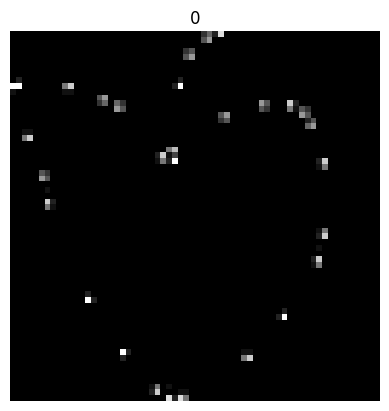

In [30]:
drawing = train_dataset.__getitem__(300)

print(drawing)
import matplotlib.pyplot as plt

# Visualize the image
plt.imshow(drawing[0].squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Hide axis for better visualization
plt.title(drawing[1])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example input data (simplified vector data from the NDJSON)
drawings = [
    [[[4,18,29,63,93,120,146,169,186,218,244,234,186,154,128,86,44,14,0],[7,51,66,90,101,106,106,101,93,67,22,23,49,58,59,53,26,16,6]],[[10,27,42,78,135,162,212,230,244],[15,39,53,67,80,74,48,35,20]],[[9,2,16,22,23,20],[18,3,0,3,8,20]],[[229,244,254,252,241],[23,17,18,22,30]],[[52,52],[52,52]],[[52,50],[52,52]],[[59,43],[69,61]]],
    [[[223,226,227,233,254,255,248,227],[35,25,2,0,2,21,27,30]],[[234,235,244,246,249],[4,8,12,19,20]],[[232,208,168,135,98,37],[28,51,104,138,164,196]],[[255,255,245,194,182,172,115,26,18,8],[25,61,106,199,213,217,219,235,235,230]],[[12,1,0,0,10,22,29,28,16,11],[193,191,194,206,219,218,206,199,194,197]],[[41,29,12],[232,228,217]],[[7,7,12,14,14,18,19,23,27,29,37],[186,199,190,193,209,200,204,204,194,203,192]],[[230,230,235,238,241,245,245],[8,15,8,17,16,4,11]],[[251,251,241,235,211,191,121,59,31],[26,69,113,126,155,168,200,215,215]],[[214,201,177,153,120,108],[72,102,131,152,167,175]]], 
    [[[2,0,4,24,41,94,160,186,189,177,151,134,94,71,30],[0,38,79,138,162,207,247,255,251,238,218,200,139,98,45]]]
]

# Reconstruct the image from the simplified drawing
index = 0
for drawing in drawings:
    reconstructed_image = train_dataset.drawing_to_image(drawing)
    index+=1
    # Display the image
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(index)
    plt.axis('off')
    plt.show()

## Just a resizing test

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

# Assuming `drawing` is the tuple as described
image_tensor = drawing[0]  # Image tensor of shape (1, H, W)
label = drawing[1]         # The label (in this case, 3)

# Convert the image to 3D (H, W, C) for easier manipulation
image_numpy = image_tensor.squeeze().cpu().numpy()

# Resize the image to a smaller size using a transformation (e.g., 128x128)
resize_transform = T.Resize((64, 64))  # Resize to 128x128
resized_image_tensor = resize_transform(image_tensor.unsqueeze(0))  # Add batch dimension

# Convert back to numpy array for visualization
resized_image_numpy = resized_image_tensor.squeeze().cpu().numpy()

# Visualize the original and resized image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image_numpy, cmap='gray')
ax[0].set_title("Original Image (256x256)")
ax[0].axis('off')

# Resized image
ax[1].imshow(resized_image_numpy, cmap='gray')
ax[1].set_title("Resized Image (64x64)")
ax[1].axis('off')

plt.show()

## Train and test algorithms

In [ ]:
# Training loop
def train_model(model, optimizer, criterion):
    model.train()
    for epoch in range(num_epochs):  # Number of epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Testing loop
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


## Model

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Run the model

In [ ]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("model structure", model)

start_time = time.time()

train_model(model, optimizer, criterion)
test_model(model)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

## Save the model

In [ ]:
# Save the trained model to a file
model_file_path = "best_model2.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

## Two other models

### Lighter

In [ ]:
class EfficientCNN(nn.Module):
    def __init__(self, num_classes):
        super(EfficientCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1 input channel, 16 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Reduce size by half
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),  # Fewer neurons in FC layer
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
lightModel = EfficientCNN(num_classes).to(device)
optimizer = optim.Adam(lightModel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("lightModel structure", lightModel)

start_time = time.time()

train_model(lightModel, optimizer, criterion)
test_model(lightModel)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

### Deeper

In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Normalize feature maps for faster convergence
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Add a third convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # More neurons for higher capacity
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
deepModel = EnhancedCNN(num_classes).to(device)
optimizer = optim.Adam(deepModel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("lightModel structure", deepModel)

start_time = time.time()

train_model(deepModel, optimizer, criterion)
test_model(deepModel)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")


In [ ]:
# Save the trained model to a file
model_file_path = "deepest_model.pth"
torch.save(deepModel.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

## Two deeper models

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_model_with_scheduler(model, optimizer, scheduler, criterion, num_epochs=10):
    print(num_epochs)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Update learning rate
        scheduler.step()
        
        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        for param_group in optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")


In [ ]:
class ResNetLikeCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Shortcut connection to match the channel dimensions
        self.shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1),  # Match input to output channels
            nn.BatchNorm2d(128)
        )

        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Ensure consistent spatial dimensions
        self.fc = None  # Placeholder, will be dynamically initialized
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # First convolution
        x = torch.relu(self.bn2(self.conv2(x)))  # Second convolution
        residual = self.shortcut(x)              # Adjust dimensions for residual
        x = torch.relu(self.bn3(self.conv3(x)) + residual)  # Add residual to output
        x = self.pool(x)  # Downsample to fixed size
        x = torch.flatten(x, 1)  # Flatten before fully connected layers
        x = self.fc(x)  # Fully connected layers
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv1(dummy_input)  # Pass through layers to determine flattened size
        conv_output = torch.relu(self.bn1(conv_output))
        conv_output = torch.relu(self.bn2(self.conv2(conv_output)))
        residual = self.shortcut(conv_output)
        conv_output = torch.relu(self.bn3(self.conv3(conv_output)) + residual)
        conv_output = self.pool(conv_output)
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        
        # Define the fully connected layers dynamically
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

# Define number of classes and input shape
input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layers
deeper1Model = ResNetLikeCNN(num_classes=num_classes)
deeper1Model.initialize_fc(input_shape)

# Move model to the device
deeper1Model = deeper1Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper1Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("ResNetLikeCNN structure:")
print(deeper1Model)

# Training and testing
start_time = time.time()
train_model(deeper1Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper1Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper1_model_dynamic.pth"
torch.save(deeper1Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

In [ ]:
class DeeperCNN2(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = None  # Placeholder, will be initialized dynamically
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for classification

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size
        x = self.fc1(x)  # First fully connected layer
        x = self.fc2(x)  # Output layer
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv_layers(dummy_input)  # Pass through conv layers
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        self.fc1 = nn.Linear(flattened_size, 512)  # Initialize fc1 with calculated size


input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layer
deeper2Model = DeeperCNN2(num_classes=num_classes)
deeper2Model.initialize_fc(input_shape)

# Move model to the device
deeper2Model = deeper2Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper2Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("DeeperCNN2 structure:")
print(deeper2Model)

# Training and testing
start_time = time.time()
train_model(deeper2Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper2Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper2_model_dynamic.pth"
torch.save(deeper2Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")